# Model Training
This notebook creates the training, validation, and test files to be used for model training. Then, the model (BiLSTM) is trained and evaluated.

## Create Files

In [249]:
import pandas as pd

folder = 'project_files'
train_df = pd.read_csv(f'{folder}/their_there_theyre_train.csv')[['clean_text', 'label']].sample(frac=1)
train_df.columns = ['text', 'label']

test_df = pd.read_csv(f'{folder}/their_there_theyre_test.csv')[['clean_text', 'label']].sample(frac=1)
test_df.columns = ['text', 'label']

def split(df, split_index):
    return df[0:split_index], df[split_index:len(df)]
train_df, val_df = split(train_df, 24000)
val_df

,text,label
3283,i often find their are no free lunches in audi...,0
21337,the claim would be true for younger people bec...,2
10474,it looks as if there is a large x in the white...,1
19557,they really do look like twins,2
8284,but until miami can pull themselves up from th...,0
...,...,...
2675,a true churning in our pastors staff and membe...,0
19875,i ve had some things on my mind lately but i m...,2
25033,these babies are really beautiful on the outsi...,2
24267,the corporate media types are just a bit scare...,2


In [250]:
# prepare actual files for classification
train_df.to_csv(f"{folder}/train.csv", index=False)
val_df.to_csv(f"{folder}/val.csv", index=False)
test_df.to_csv(f"{folder}/test.csv", index=False)

In [299]:
import pandas as pd

print(len(train_df))
print(len(val_df))
print(len(test_df))

24000
3000
3000


## Prepare Data

In [252]:
# Libraries
import pandas as pd
import torch

# Preliminaries
from torchtext.data import Field, TabularDataset, BucketIterator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Models
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Training
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [253]:
# Fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.long) # or dtype=torch.long
text_field = Field(include_lengths=True, batch_first=True, lower=True) # tokenize='spacy', tokenizer_language="en_core_web_sm",
fields = [('text', text_field), ('label', label_field)]

# TabularDataset
folder = 'Vantage_Labs_Project_Files'
train, valid, test = TabularDataset.splits(path=folder, train="train.csv", validation="val.csv", test="test.csv",
                                           format='CSV', fields=fields, skip_header=True)

# Iterators
BATCH_SIZE = 32
train_iter = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary
text_field.build_vocab(train, min_freq=3)
# text_field.build_vocab(train, vectors="glove.6B.100d")

In [271]:
len(train_iter)

750

In [272]:
len(text_field.vocab)

12645

## Define Model and Evaluation Functions

In [273]:
class LSTM(nn.Module):
    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300, # 300
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.linear = nn.Linear(dimension, 3)
        self.drop = nn.Dropout(p=0.2) # 0.5 
    
    def forward(self, x, l):
        x = self.embedding(x)
        x = self.drop(x)
        lstm_out, (ht, ct) = self.lstm(x)
        return self.linear(ht[-1])

In [274]:
# Save and Load Functions # https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0
def save_checkpoint(save_path, model, optimizer, valid_loss):
    if save_path == None:
        return
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model, optimizer):
    if load_path==None:
        return
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']

def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
    if save_path == None:
        return
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_metrics(load_path):
    if load_path==None:
        return
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

## Training and Evaluation

In [276]:
# Training Function
def train(model,
          optimizer,
          # criterion = nn.NLLLoss(),
          criterion = nn.CrossEntropyLoss,
          # criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = 'Vantage_Labs_Project_Files',
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for x in train_loader: # , (text, text_len)), _ 
            labels = x.label.to(device)
            text = x.text[0].to(device)
            len_text = x.text[1].cpu() # https://github.com/pytorch/pytorch/issues/43227
            
            output = model(text, len_text)
            output = torch.softmax(output, dim=1)
            # print(output)
            # print(labels)
            CEL = criterion()
            loss = CEL(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for y in valid_loader:
                    labels = y.label.to(device)
                    text = y.text[0].to(device)
                    len_text = y.text[1].cpu()
                    # text_len = text_len.to(device)
                    output = model(text, len_text)
                    output = torch.softmax(output, dim=1)
                    
                    CEL = criterion()
                    loss = CEL(output, labels)
                    valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train(model=model, optimizer=optimizer, num_epochs=10)

Epoch [1/10], Step [375/7500], Train Loss: 0.9407, Valid Loss: 0.8235
Model saved to ==> Vantage_Labs_Project_Files/model.pt
Model saved to ==> Vantage_Labs_Project_Files/metrics.pt
Epoch [1/10], Step [750/7500], Train Loss: 0.8206, Valid Loss: 0.7488
Model saved to ==> Vantage_Labs_Project_Files/model.pt
Model saved to ==> Vantage_Labs_Project_Files/metrics.pt
Epoch [2/10], Step [1125/7500], Train Loss: 0.7058, Valid Loss: 0.7066
Model saved to ==> Vantage_Labs_Project_Files/model.pt
Model saved to ==> Vantage_Labs_Project_Files/metrics.pt
Epoch [2/10], Step [1500/7500], Train Loss: 0.7025, Valid Loss: 0.6945
Model saved to ==> Vantage_Labs_Project_Files/model.pt
Model saved to ==> Vantage_Labs_Project_Files/metrics.pt
Epoch [3/10], Step [1875/7500], Train Loss: 0.6571, Valid Loss: 0.6701
Model saved to ==> Vantage_Labs_Project_Files/model.pt
Model saved to ==> Vantage_Labs_Project_Files/metrics.pt
Epoch [3/10], Step [2250/7500], Train Loss: 0.6644, Valid Loss: 0.6533
Model saved to =

Model loaded from <== Vantage_Labs_Project_Files/metrics.pt


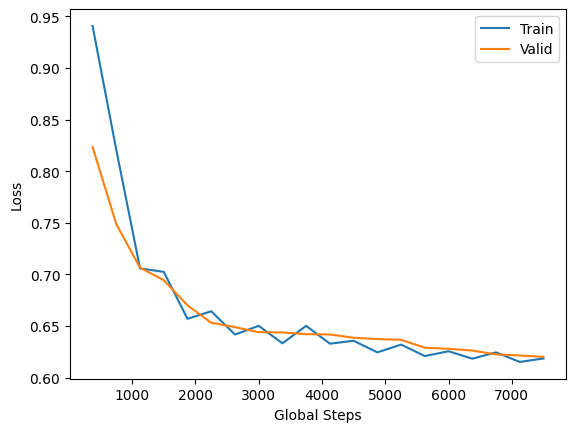

In [277]:
import matplotlib.pyplot as plt

train_loss_list, valid_loss_list, global_steps_list = load_metrics(folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [298]:
# Evaluation Function
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for x in test_loader:           
            labels = x.label.to(device)
            text = x.text[0].to(device)
            len_text = x.text[1].cpu()
            output = model(text, len_text)
            # print(output)
            # print(output)
            preds = torch.argmax(output, dim=1)
            # print(preds)
            # print(labels)
            # output = (output > threshold).int()
            y_pred.extend(preds.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[0,1,2], digits=4))
    
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.0001)

load_checkpoint(folder + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

Model loaded from <== Vantage_Labs_Project_Files/model.pt
Classification Report:
              precision    recall  f1-score   support

           0     0.9185    0.9130    0.9157      1000
           1     0.9091    0.9100    0.9095      1000
           2     0.9851    0.9900    0.9875      1000

    accuracy                         0.9377      3000
   macro avg     0.9376    0.9377    0.9376      3000
weighted avg     0.9376    0.9377    0.9376      3000



## References:
https://pytorch.org/docs/master/generated/torch.nn.LSTM.html#torch.nn.LSTM

https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0

https://towardsdatascience.com/multiclass-text-classification-using-lstm-in-pytorch-eac56baed8df

https://torchtext.readthedocs.io/en/latest/data.html#tabulardataset

https://anie.me/On-Torchtext/

https://github.com/pytorch/pytorch/issues/43227

https://towardsdatascience.com/cross-entropy-negative-log-likelihood-and-all-that-jazz-47a95bd2e81

https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html#lstm-s-in-pytorch